In [1]:
# !pip install numpy opencv-python pillow tensorflow keras imutils scikit-learn matplotlib kagglehub matplotlib 

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

# print("Path to dataset files:", path)

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (SeparableConv2D, MaxPooling2D, Flatten,
                                     Dropout, Dense, Activation, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Configuration
INPUT_DATASET = r"C:\Users\DELL\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1"
BASE_PATH = r""
TRAIN_PATH = os.path.join(BASE_PATH, "training")
VAL_PATH = os.path.join(BASE_PATH, "validation")
TEST_PATH = os.path.join(BASE_PATH, "testing")

TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
IMG_DIMS = (48, 48)
NUM_CLASSES = 2
BATCH_SIZE = 32
NUM_EPOCHS = 40
INIT_LR = 1e-2


In [2]:
from imutils import paths

def build_dataset_structure():
    image_paths = list(paths.list_images(INPUT_DATASET))
    random.seed(7)
    random.shuffle(image_paths)

    i = int(len(image_paths) * TRAIN_SPLIT)
    train_paths = image_paths[:i]
    test_paths = image_paths[i:]

    j = int(len(train_paths) * VAL_SPLIT)
    val_paths = train_paths[:j]
    train_paths = train_paths[j:]

    datasets = [("training", train_paths, TRAIN_PATH),
                ("validation", val_paths, VAL_PATH),
                ("testing", test_paths, TEST_PATH)]

    for set_type, paths_list, base_path in datasets:
        print(f"Building {set_type} set")
        for path in paths_list:
            label = path.split(os.path.sep)[-1][-5:-4]
            label_path = os.path.join(base_path, label)
            os.makedirs(label_path, exist_ok=True)
            shutil.copy2(path, os.path.join(label_path, os.path.basename(path)))


In [3]:
def build_model(input_shape=(48, 48, 3), classes=2):
    model = Sequential()
    channel_dim = -1

    model.add(SeparableConv2D(32, (3, 3), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(SeparableConv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(SeparableConv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(SeparableConv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(SeparableConv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(SeparableConv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model


In [4]:
def train_and_evaluate():
    train_aug = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="nearest"
    )

    val_aug = ImageDataGenerator(rescale=1 / 255.0)

    train_gen = train_aug.flow_from_directory(
        TRAIN_PATH,
        class_mode="categorical",
        target_size=IMG_DIMS,
        color_mode="rgb",
        shuffle=True,
        batch_size=BATCH_SIZE
    )

    val_gen = val_aug.flow_from_directory(
        VAL_PATH,
        class_mode="categorical",
        target_size=IMG_DIMS,
        color_mode="rgb",
        shuffle=False,
        batch_size=BATCH_SIZE
    )

    test_gen = val_aug.flow_from_directory(
        TEST_PATH,
        class_mode="categorical",
        target_size=IMG_DIMS,
        color_mode="rgb",
        shuffle=False,
        batch_size=BATCH_SIZE
    )

    # Class Weights
    labels = train_gen.classes
    class_totals = np.bincount(labels)
    class_weight = {i: max(class_totals) / class_totals[i] for i in range(NUM_CLASSES)}

    model = build_model(input_shape=(48, 48, 3), classes=NUM_CLASSES)
    opt = Adam(learning_rate=INIT_LR)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    H = model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // BATCH_SIZE,
        validation_data=val_gen,
        validation_steps=val_gen.samples // BATCH_SIZE,
        class_weight=class_weight,
        epochs=NUM_EPOCHS
    )

    # Evaluation
    test_gen.reset()
    preds = model.predict(test_gen, steps=(test_gen.samples // BATCH_SIZE) + 1)
    pred_indices = np.argmax(preds, axis=1)

    print("\nClassification Report:")
    print(classification_report(test_gen.classes, pred_indices, target_names=test_gen.class_indices.keys()))

    cm = confusion_matrix(test_gen.classes, pred_indices)
    print("Confusion Matrix:\n", cm)

    total = cm.sum()
    accuracy = np.trace(cm) / total
    specificity = cm[1,1] / (cm[1,1] + cm[1,0])
    sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")

    # Plotting
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 6))
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()


Building training set
Building validation set
Building testing set
Found 255815 images belonging to 2 classes.
Found 42660 images belonging to 2 classes.
Found 99906 images belonging to 2 classes.


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
7994/7994 ━━━━━━━━━━━━━━━━━━━━ 6410s 800ms/step - accuracy: 0.7908 - loss: 0.6930 - val_accuracy: 0.8196 - val_loss: 0.4201
Epoch 2/40
   1/7994 ━━━━━━━━━━━━━━━━━━━━ 15:34 117ms/step - accuracy: 0.7500 - loss: 0.6924

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7994/7994 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7500 - loss: 0.6924 - val_accuracy: 0.8166 - val_loss: 0.4292
Epoch 3/40
7994/7994 ━━━━━━━━━━━━━━━━━━━━ 1475s 184ms/step - accuracy: 0.8190 - loss: 0.5895 - val_accuracy: 0.7832 - val_loss: 0.4724
Epoch 4/40
7994/7994 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.8438 - loss: 0.6216 - val_accuracy: 0.7771 - val_loss: 0.4853
Epoch 5/40
7994/7994 ━━━━━━━━━━━━━━━━━━━━ 1442s 180ms/step - accuracy: 0.8307 - loss: 0.5699 - val_accuracy: 0.7492 - val_loss: 0.8552
Epoch 6/40
7994/7994 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7812 - loss: 0.5701 - val_accuracy: 0.7528 - val_loss: 0.8137
Epoch 7/40
7994/7994 ━━━━━━━━━━━━━━━━━━━━ 1493s 187ms/step - accuracy: 0.8385 - loss: 0.5510 - val_accuracy: 0.8311 - val_loss: 0.4143
Epoch 8/40
7994/7994 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.6875 - loss: 0.4910 - val_accuracy: 0.8334 - val_loss: 0.4089
Epoch 9/40
7994/7994 ━━━━━━━━━━━━━━━━━━━━ 1460s 183ms/step - accuracy: 0.8383 - lo

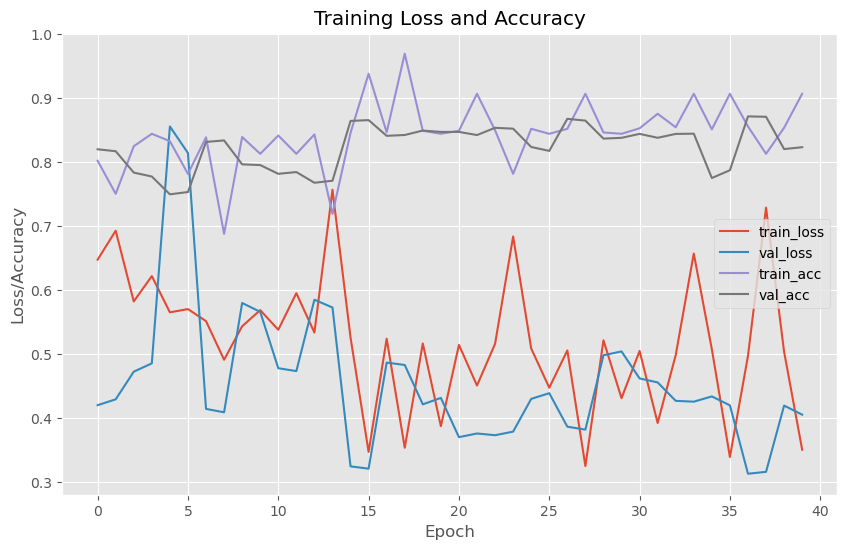

In [5]:
build_dataset_structure()
train_and_evaluate()
